In [42]:
from uproot_io import Events, View
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

In [12]:
events1 = Events(r"C:\Users\andre\Desktop\Physics Project\bigdata\CheatedRecoFile_1.root")
events2 = Events(r"C:\Users\andre\Desktop\Physics Project\bigdata\CheatedRecoFile_2.root")
events3 = Events(r"C:\Users\andre\Desktop\Physics Project\bigdata\CheatedRecoFile_3.root")
events4 = Events(r"C:\Users\andre\Desktop\Physics Project\bigdata\CheatedRecoFile_4.root")
events5 = Events(r"C:\Users\andre\Desktop\Physics Project\bigdata\CheatedRecoFile_5.root")

In [13]:
# getting the event indices and finding the number of events in each file
numbers1 = np.array(list(set(events1.event_number)))
numbers2 = np.array(list(set(events2.event_number)))
numbers3 = np.array(list(set(events3.event_number)))
numbers4 = np.array(list(set(events4.event_number)))
numbers5 = np.array(list(set(events5.event_number)))
len(numbers1), len(numbers2), len(numbers3), len(numbers4), len(numbers5)

(9310, 9265, 9310, 9257, 9282)

In [15]:
def process_numbers(numbers, events):
    labels = []
    for n in numbers:
        mcp = []
        index = np.where(events.event_number == n)[0]

        for i in index:
            parent = events.reco_parent_index[i]
            if parent == 0:
                mcp.append(events.mc_pdg[i])

        if 13 in mcp or -13 in mcp:
            labels.append(0)
        elif 11 in mcp or -11 in mcp:
            labels.append(1)
        else:
            labels.append(2)
    return labels

def oneHotLabelling(numbers_list, events_list):
    labels = []
    for numbers, events in zip(numbers_list, events_list):
        labels.extend(process_numbers(numbers, events))
    return np.array(labels)

In [16]:
numbers_list = [numbers1, numbers2, numbers3, numbers4, numbers5]
events_list = [events1, events2, events3, events4, events5]
truth = oneHotLabelling(numbers_list, events_list)

46424

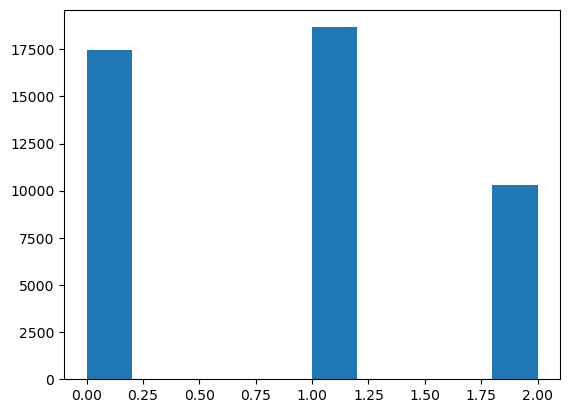

In [17]:
plt.hist(truth)
len(truth)

In [18]:
# training data

def fit_line(x, y):
    A = np.vstack([x, np.ones_like(x)]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

def calculate_residuals(x, y, m, c):
    #y_predicted = (m*x) + c
    perpdist = abs(((-m*x) + y - c) / np.sqrt(m**2 + 1))
    #residuals = np.abs(perpdist - y_predicted)
    return perpdist

def makedata(numbers_list, events_list):
    data = []
    datamuon = []
    dataelectron = []
    label = []
    labelmuon = []
    labelelectron = []
    truth = []
    
    for numbers, events in zip(numbers_list, events_list):
        
        for n in numbers:
            mcp = []
            idx = np.where(events.event_number == n)[0]

            for i in idx:
                parent = events.reco_parent_index[i]
                if parent == 0:
                    mcp.append(events.mc_pdg[i])
            
            nhits = 0
            big = []
            for i in idx:
                x = events.reco_hits_x_w[i]
                z = events.reco_hits_w[i]
                pdg = events.mc_pdg[i]
                purity = events.purity[i]
                complete = events.completeness[i]

                if len(x) > 10 and pdg != 0 and purity > 0.75 and complete > 0.75:
                    if len(x) > nhits:
                        nhits = len(x)
                        big.append(i)

            if len(big) != 0:
                i = big[-1]
                
                if 13 in mcp or -13 in mcp:
                    truth.append(0)
                elif 11 in mcp or -11 in mcp:
                    truth.append(1)
                else:
                    truth.append(2)

    
                # line of best fit
                gradients = []
                intercepts = []

                xmax = -1000
                xmin = 1000
                zmax = -1000
                zmin = 1000
    
                x0 = events.reco_hits_x_w[i]
                z0 = events.reco_hits_w[i]
                if len(x0) > 0:
                    if max(x0) >= xmax:
                        xmax = max(x0)
                    if min(x0) <= xmin:
                        xmin = min(x0)
                if len(z0) > 0:
                    if max(z0) >= zmax:
                        zmax = max(z0)
                    if min(z0) <= zmin:
                        zmin = min(z0)

                xlen = 0.1*(xmax - xmin)
                zlen = 0.1*(zmax - zmin)


                # features
                entry = []
                entrymuon = []
                entryelectron = []

                # hits, pdg code, purity, completeness, adc values, vertex coordinates

                x = events.reco_hits_x_w[i]
                z = events.reco_hits_w[i]
                pdg = events.mc_pdg[i]
                purity = events.purity[i]
                complete = events.completeness[i]

                adc = events.reco_adcs_w[i]
                vx = events.reco_particle_vtx_x[i]
                vz = events.reco_particle_vtx_w[i]


                if pdg == 22. or pdg == -11. or pdg == 11.:
                    label.append(0) # showers
                else:
                    label.append(1) # tracks
                    
                if pdg == 13. or pdg == -13.:
                    labelmuon.append(1) # muon
                else:
                    labelmuon.append(0) # other
                
                if pdg == 11. or pdg == -11.:
                    labelelectron.append(1) # electron
                else:
                    labelelectron.append(0) # other


                best_inliers = []
                best_model = None
                sample_size = 10
                max_iterations = 100

                for _ in range(max_iterations):
                    sample_size = min(sample_size, len(x))
                    sample_indices = np.random.choice(len(x), size=sample_size, replace=False)
                    x_sample = x[sample_indices]
                    z_sample = z[sample_indices]

                    m, c = fit_line(x_sample, z_sample)
                    residuals = calculate_residuals(x, z, m, c)
                    inliers = np.where(residuals < (0.15*xlen))[0]

                    if len(inliers) > len(best_inliers):
                        best_inliers = inliers
                        best_model = (m, c)

                if len(best_inliers) > 0:
                    m, c = best_model

                    gradients.append(m)
                    intercepts.append(c)

                    # changing the coordinates into longitudinal and tranverse from best line

                    znew = z - c
                    angle = -math.atan(m)
                    l = x * np.cos(angle) - znew * np.sin(angle)
                    t = x * np.sin(angle) + znew * np.cos(angle)

                    # feature 1: proximal hits within 5% of transverse range of the hits.

                    tdiff = np.abs(max(t)-min(t))
                    margin = tdiff*0.05
                    inside = [x for x in t if x <= margin and x >= -margin]
                    entry.append(len(inside)/len(t))

                    # feature 2: the standard deviation of the last 30% of a topology

                    p1 = int(0.7 * len(t))
                    X = t[p1:]
                    Xvar = np.var(X)

                    p2 = int(0.3 * len(t))
                    Y = t[:p2]
                    Yvar = np.var(Y)

                    if  Yvar > Xvar:
                        resultY = np.sqrt(Yvar)
                        entry.append(resultY)           
                    else:
                        resultX = np.sqrt(Xvar)
                        entry.append(resultX)

                    # feature 3: the hits per length

                    above = np.sum(t > 0)
                    below = np.sum(t < 0)

                    lmin, lmax = np.min(l), np.max(l)
                    length = lmax - lmin

                    if above == 0 or below == 0 or length == 0:
                        entry.append(2)

                    else:
                        # If symmetric, this should be close to 1, otherwise > 1
                        hits = (above + below) / length
                        entry.append(hits)


                    # feature 4: energy in the last 10% of the track

                    vznew = vz - c

                    vl = vx * np.cos(angle) - vznew * np.sin(angle)
                    vt = vx * np.sin(angle) + vznew * np.cos(angle)

                    if max(l) < vl:
                        l *= -1

                    combined = list(zip(l, t, adc))
                    sort = sorted(combined, key = lambda coord: coord[0])

                    lnew, tnew, adcnew = zip(*sort)

                    percent = int(0.9 * len(adcnew))
                    X = adcnew[percent:]
                    Xsum = np.sum(X)

                    total = np.sum(adcnew)
                    result = Xsum / total

                    entry.append(result)

                    # feature 5: mean connection distance

                    total_distance = 0.0
                    for j in range(len(x) - 1):
                        distance = np.sqrt((x[j+1] - x[j])**2 + (z[j+1] - z[j])**2)
                        total_distance += distance
                    meandist = total_distance/(len(x)-1)
                    entry.append(meandist)
                    
                    
                    # NEW 1: Length

                    lmin, lmax = np.min(l), np.max(l)
                    length = lmax - lmin
                    entrymuon.append(length)

                    # NEW 2: Sum of charge 

                    summ = np.sum(adc)
                    charge = summ/length
                    entrymuon.append(charge)                    
                    
                    # NEW 1: Vtx dist
            
                    nx = events.true_neutrino_vtx_x[i]
                    nw = events.true_neutrino_vtx_w[i]
                    dists = []
                    for n, i in enumerate(x):
                        dist = np.sqrt((nx - i) ** 2 + (nw - z[n]) ** 2)
                        dists.append(dist)
                    entryelectron.append(min(dists))

                    #px = x[0]
                    #pw = z[0]
                    #nx = events.true_neutrino_vtx_x[i]
                    #nw = events.true_neutrino_vtx_w[i]

                    #px = events.reco_particle_vtx_3d_x[i]
                    #py = events.reco_particle_vtx_3d_y[i]
                    #pz = events.reco_particle_vtx_3d_z[i]
                    #nx = events.neutrino_vtx_3d_x[i]
                    #ny = events.neutrino_vtx_3d_y[i]
                    #nz = events.neutrino_vtx_3d_z[i]

                    #pcord = np.array((px, pw))
                    #ncord = np.array((nx, nw))
                    #squared_diff = (pcord - ncord) ** 2
                    #distance = np.sqrt(np.sum(squared_diff))
                    #entry.append(distance)

                    # NEW 2: Charge at start

                    lmin, lmax = np.min(l), np.max(l)
                    length = lmax - lmin

                    vznew = vz - c

                    vl = vx * np.cos(angle) - vznew * np.sin(angle)
                    vt = vx * np.sin(angle) + vznew * np.cos(angle)

                    if max(l) < vl:
                        l *= -1

                    combined = list(zip(l, t, adc))
                    sort = sorted(combined, key = lambda coord: coord[0])

                    lnew, tnew, adcnew = zip(*sort)

                    percent = int(0.1 * len(adcnew))
                    X = adcnew[:percent]
                    Xsum = np.sum(X)
                    newww = Xsum/(0.1*length)
                    entryelectron.append(newww)                    
                    
                    data.append(entry)
                    datamuon.append(entrymuon)
                    dataelectron.append(entryelectron)


                else:
                    entry.append(0.1)  # proximal hits
                    entry.append(1.5)  # standard deviation
                    entry.append(2)    # hits per length
                    entry.append(0.25) # energy
                    entry.append(1)    # mean connection distance
                    data.append(entry)
                    
                    entrymuon.append(150)
                    entrymuon.append(250)
                    datamuon.append(entrymuon)
                    
                    entryelectron.append(1)
                    entryelectron.append(250)
                    dataelectron.append(entryelectron)

    return data, datamuon, dataelectron, label, labelmuon, labelelectron, truth

In [19]:
fall, ftrk, fshw, lall, ltrk, lshw, truth = makedata(numbers_list, events_list)

In [23]:
fall = np.array(fall)
ftrk = np.array(ftrk)
fshw = np.array(fshw)
lall = np.array(lall)
ltrk = np.array(ltrk)
lshw = np.array(lshw)
truth = np.array(truth)

np.save("fall", fall)
np.save("ftrk", ftrk)
np.save("fshw", fshw)
np.save("lall", lall)
np.save("ltrk", ltrk)
np.save("lshw", lshw)
np.save("truth", truth)

(array([17389.,     0.,     0.,     0.,     0., 18531.,     0.,     0.,
            0.,  9713.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

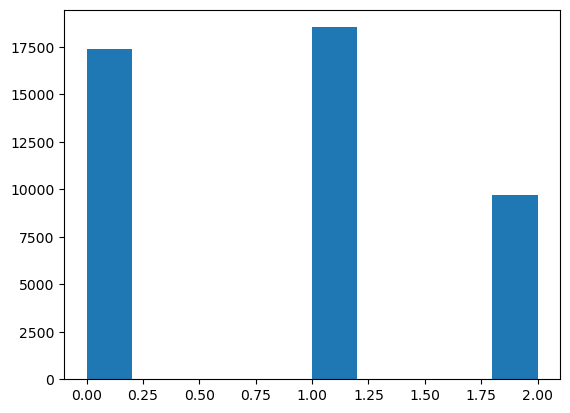

In [34]:
plt.hist(truth)

In [35]:
indices = np.random.choice(len(fall), size=int(0.6 * len(fall)), replace=False)
x_train = fall[indices]
y_train = lall[indices]
x_test = np.delete(fall, indices, axis=0)
y_test = np.delete(lall, indices, axis=0)

In [50]:
cutftrk = np.delete(ftrk, indices, axis=0)
cutltrk = np.delete(ltrk, indices, axis=0)
cutfshw = np.delete(fshw, indices, axis=0)
cutlshw = np.delete(lshw, indices, axis=0)
cuttruth = np.delete(truth, indices, axis=0)

In [36]:
# Create the BDT with a base decision tree classifier (this is the default base classifier, included for illustration)
base = DecisionTreeClassifier(max_depth=14)
bdt = AdaBoostClassifier(estimator=base, n_estimators=100, random_state=0)
# Fit the BDT to the training set
bdt.fit(x_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=14),
                   n_estimators=100, random_state=0)

In [37]:
# Check the training set classification performance
bdt.score(x_train, y_train)

1.0

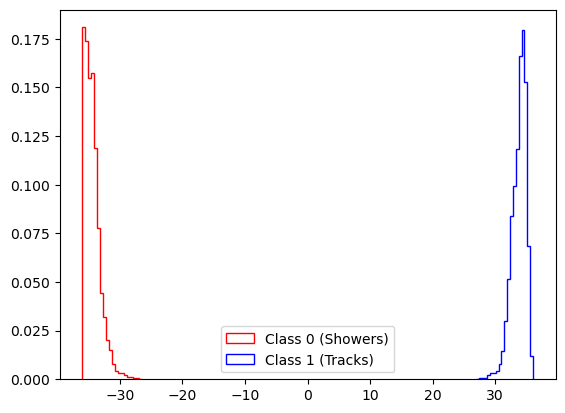

In [38]:
f0 = bdt.decision_function(x_train)
min_f = np.round(np.min(f0), 1)
max_f = np.round(np.max(f0), 1)
#bins = np.linspace(min_f, max_f, 4 * int((max_f - min_f) / 0.1) + 1)
bins = 20
cls_0_f0 = f0[np.where(y_train == 0)]
cls_1_f0 = f0[np.where(y_train == 1)]
weights_0 = np.ones_like(cls_0_f0) / len(cls_0_f0)
weights_1 = np.ones_like(cls_1_f0) / len(cls_1_f0)
plt.hist(cls_0_f0, color='r', weights=weights_0, bins=bins, histtype='step', label='Class 0 (Showers)')
plt.hist(cls_1_f0, color='b', weights=weights_1, bins=bins, histtype='step', label='Class 1 (Tracks)')
plt.legend()

In [39]:
# Check the test set classification performance
bdt.score(x_test, y_test)

0.989591322449874

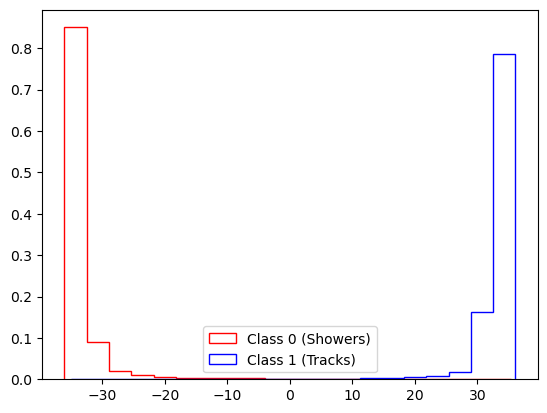

In [40]:
f = bdt.decision_function(x_test)
min_f = np.round(np.min(f), 1)
max_f = np.round(np.max(f), 1)
#bins = np.linspace(min_f, max_f, 4 * int((max_f - min_f) / 0.1) + 1)
bins = 20
cls_0_f = f[np.where(y_test == 0)]
cls_1_f = f[np.where(y_test == 1)]
weights_0 = np.ones_like(cls_0_f) / len(cls_0_f)
weights_1 = np.ones_like(cls_1_f) / len(cls_1_f)
plt.hist(cls_0_f, color='r', weights=weights_0, bins=bins, histtype='step', label='Class 0 (Showers)')
plt.hist(cls_1_f, color='b', weights=weights_1, bins=bins, histtype='step', label='Class 1 (Tracks)')
plt.legend()

In [45]:
tracks = []
showers = []
for n, i in enumerate(f):
    if i >= 3.5:
        tracks.append(n)
    if i < 3.5:
        showers.append(n)

In [49]:
len(tracks), len(showers)

(8918, 9336)

In [64]:
np.random.shuffle(tracks)
split = int(len(tracks)*0.6)
tracktraining = tracks[:split]
tracktesting = tracks[split:]

x_train_track = cutftrk[tracktraining]
y_train_track = cutltrk[tracktraining]
x_test_track = cutftrk[tracktesting]
y_test_track = cutltrk[tracktesting]

tracktruth = cuttruth[tracktesting]

In [65]:
np.random.shuffle(showers)
split = int(len(showers)*0.6)
showertraining = showers[:split]
showertesting = showers[split:]

x_train_shower = cutfshw[showertraining]
y_train_shower = cutlshw[showertraining]
x_test_shower = cutfshw[showertesting]
y_test_shower = cutlshw[showertesting]

showertruth = cuttruth[showertesting]

In [66]:
np.shape(x_test_shower)

(3735, 2)

In [67]:
# Create the BDT with a base decision tree classifier (this is the default base classifier, included for illustration)
base = DecisionTreeClassifier(max_depth=14)
bdtt = AdaBoostClassifier(estimator=base, n_estimators=100, random_state=0)
# Fit the BDT to the training set
bdtt.fit(x_train_track, y_train_track)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=14),
                   n_estimators=100, random_state=0)

In [68]:
# Check the training set classification performance
bdtt.score(x_test_track, y_test_track)

0.7996076233183856

In [69]:
#allll = np.concatenate((x_train_trk, x_test_trk))

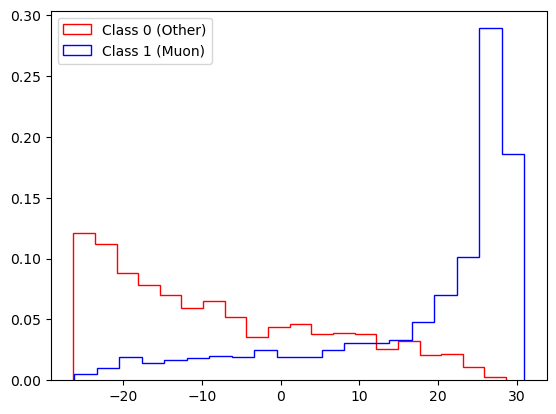

In [78]:
ft = bdtt.decision_function(x_test_track)
min_f = np.round(np.min(ft), 1)
max_f = np.round(np.max(ft), 1)
#bins = np.linspace(min_f, max_f, 4 * int((max_f - min_f) / 0.1) + 1)
bins = 20
cls_0_f = ft[np.where(y_test_track == 0)]
cls_1_f = ft[np.where(y_test_track == 1)]
weights_0 = np.ones_like(cls_0_f) / len(cls_0_f)
weights_1 = np.ones_like(cls_1_f) / len(cls_1_f)
plt.hist(cls_0_f, color='r', weights=weights_0, bins=bins, histtype='step', label='Class 0 (Other)')
plt.hist(cls_1_f, color='b', weights=weights_1, bins=bins, histtype='step', label='Class 1 (Muon)')
plt.legend()

In [71]:
# Create the BDT with a base decision tree classifier (this is the default base classifier, included for illustration)
base = DecisionTreeClassifier(max_depth=14)
bdts = AdaBoostClassifier(estimator=base, n_estimators=100, random_state=0)
# Fit the BDT to the training set
bdts.fit(x_train_shower, y_train_shower)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=14),
                   n_estimators=100, random_state=0)

In [72]:
# Check the training set classification performance
bdts.score(x_test_shower, y_test_shower)

0.8358768406961178

In [73]:
#allll = np.concatenate((x_train_shw, x_test_shw))

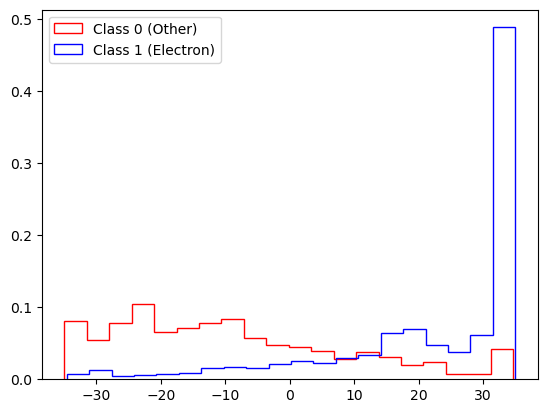

In [74]:
fs = bdts.decision_function(x_test_shower)
min_f = np.round(np.min(fs), 1)
max_f = np.round(np.max(fs), 1)
#bins = np.linspace(min_f, max_f, 4 * int((max_f - min_f) / 0.1) + 1)
bins = 20
cls_0_f = fs[np.where(y_test_shower == 0)]
cls_1_f = fs[np.where(y_test_shower == 1)]
weights_0 = np.ones_like(cls_0_f) / len(cls_0_f)
weights_1 = np.ones_like(cls_1_f) / len(cls_1_f)
plt.hist(cls_0_f, color='r', weights=weights_0, bins=bins, histtype='step', label='Class 0 (Other)')
plt.hist(cls_1_f, color='b', weights=weights_1, bins=bins, histtype='step', label='Class 1 (Electron)')
plt.legend()

[[2124   92  552]
 [  97 2335  547]
 [ 241  199 1116]]


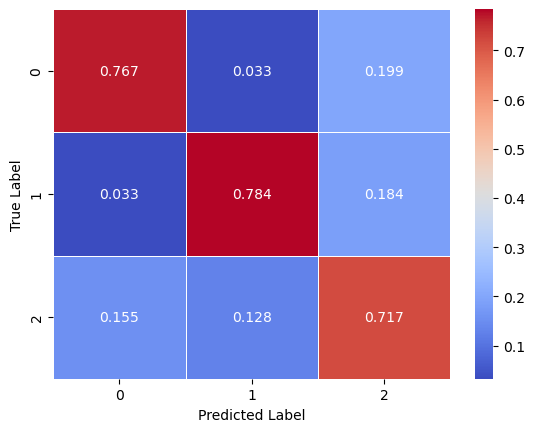

In [83]:
tcut = -3.5
scut = -0.5
predictions = []
for n, i in enumerate(ft):
    if i >= tcut:
        predictions.append(0)
    if i < tcut:
        predictions.append(2)
for n, i in enumerate(fs):
    if i >= scut:
        predictions.append(1)
    if i < scut:
        predictions.append(2)
truthh = np.concatenate((tracktruth,showertruth))
conf_matrix = confusion_matrix(truthh, predictions)
conf_matrix_decimals = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
heatmap = sns.heatmap(conf_matrix_decimals, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, square=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
print(conf_matrix)

In [79]:
TIT = cls_1_f
SIT = cls_0_f

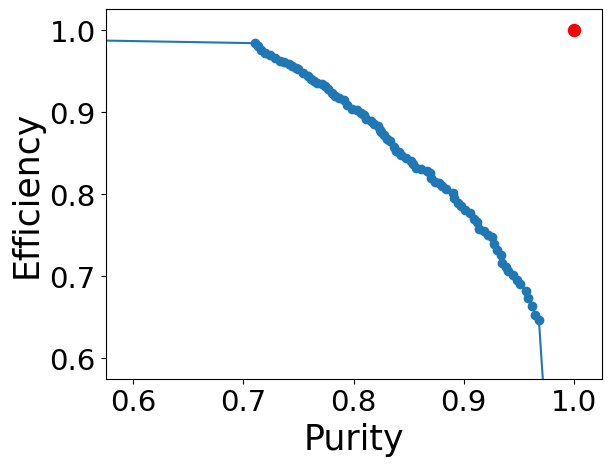

Best cut: -3.5
At distance: 0.21314488270496793
With AUC: 0.9331203213462075


In [82]:
cuts = np.arange(-20, 20, 0.5)
efficiency = []
purity = []

purity.append(0)
efficiency.append(1)

for i in cuts:
    goodtrk = []
    badtrk = []
    goodshw = []
    badshw = []
    for n in TIT:
        if n >= i:
            goodtrk.append(n)
        else:
            badtrk.append(n)
    for k in SIT:
        if k >= i:
            badshw.append(k)
        else:
            goodshw.append(k)

    eff = len(goodtrk)/(len(TIT))
    pur = len(goodtrk)/(len(goodtrk)+len(badshw))

    efficiency.append(eff)
    purity.append(pur)

purity.append(1)
efficiency.append(0)

plt.scatter(purity, efficiency)
plt.plot(purity, efficiency)
plt.scatter(1, 1, s=75, c='r')
#plt.xlim(0.6,1.025)
#plt.ylim(0.6,1.025)
plt.xlabel('Purity', fontsize=25)
plt.ylabel('Efficiency', fontsize=25)
#plt.title('ROC Curve for Track Likelihood')
plt.xticks(np.arange(0.6, 1.1, step=0.1), fontsize = 21)
plt.yticks(np.arange(0.6, 1.1, step=0.1), fontsize = 21)
plt.xlim(0.575,1.025)
plt.ylim(0.575,1.025)
plt.show()

np.save("CE_BDT", efficiency)
np.save("CP_BDT", purity)

area = np.trapz(efficiency, x=purity)

point = np.array([1, 1])
data_points = np.column_stack((purity, efficiency))
distances = np.linalg.norm(data_points - point, axis=1)
closest_index = np.argmin(distances)
closest_point = data_points[closest_index]
dist = distances[closest_index]
cutpoint = cuts[closest_index]

print('Best cut:', cutpoint)
print('At distance:', dist)
print('With AUC:', area)

#efficiency (true tracks as tracks/total true tracks)
#purity (true tracks as tracks/number we have called tracks)

In [63]:
TTAT = []
TTAS = []
TSAT = []
TSAS = []

for i, n in enumerate(TIT):
    if n >= cutpoint:
        TTAT.append(n)
        leng1.append(trkleng[i])
        part1.append(trkpart[i])
    if n < cutpoint:
        TTAS.append(n)
        leng2.append(trkleng[i])
        part2.append(trkpart[i])
        
for i, k in enumerate(SIT):
    if k >= cutpoint:
        TSAT.append(k)
        leng3.append(shwleng[i])
        part3.append(shwpart[i])
    if k < cutpoint:
        TSAS.append(k)
        leng4.append(shwleng[i])
        part4.append(shwpart[i])

TTATprob = len(TTAT)/(len(TTAT)+len(TTAS))
TTASprob = len(TTAS)/(len(TTAT)+len(TTAS))
TSATprob = len(TSAT)/(len(TSAT)+len(TSAS))
TSASprob = len(TSAS)/(len(TSAT)+len(TSAS))

confusion = np.array(([TTATprob, TTASprob],[TSATprob, TSASprob]))
print(confusion)

e1 = np.sqrt((TTATprob*(1-TTATprob))/len(TTAT))
e2 = np.sqrt((TTASprob*(1-TTASprob))/len(TTAS))
e3 = np.sqrt((TSATprob*(1-TSATprob))/len(TSAT))
e4 = np.sqrt((TSASprob*(1-TSASprob))/len(TSAS))

error = np.array(([e1, e2],[e3, e4]))
print(error)

NameError: name 'leng1' is not defined

In [ ]:
import seaborn as sns
variable_names1 = ['as Track', 'as Shower']
variable_names2 = ['True Track', 'True Shower']

annot_arr = np.array([['0.980±0.002','0.02±0.01'],
                      ['0.03±0.01','0.972±0.002']], dtype = str)

plt.figure(figsize = (3.5,1))
heatmap = sns.heatmap(confusion, annot=annot_arr, cmap='coolwarm', fmt="s", linewidths=.5, square=False)
heatmap.set_xticklabels(variable_names1, rotation=0)
heatmap.set_yticklabels(variable_names2, rotation=0)
#plt.title("Confusion Matrix")±±±±±
plt.show()

In [ ]:
#print(max(trkleng))
#print(max(shwleng))
bin_edges = np.arange(10, 310, 10)

hist1, _ = np.histogram(trkleng, bins=bin_edges)
hist2, _ = np.histogram(leng1, bins=bin_edges)

#hist1_normalized = hist1 / len(trkleng)
#hist2_normalized = hist2 / len(leng1)

plt.bar(bin_edges[:-1], hist1, width=10, align='edge', alpha=0.75, label='All True Showers')
plt.bar(bin_edges[:-1], hist2, width=10, align='edge', alpha=0.75, label='True Showers as Showers')
#plt.title('')
plt.xlabel('n Hits In Particle')
plt.legend(loc='upper center')
plt.show()

xvalues = np.arange(10, 300, 10)
eff = hist2/hist1
error = []

for i, val in enumerate(eff):
    err = np.sqrt((val*(1-val))/(hist1[i]+hist2[i]))
    error.append(err)

#print(xvalues)
#print(eff)
#print(error)

plt.errorbar(xvalues, eff, yerr=error, fmt='o', elinewidth=2, ecolor='red', capsize=5, ms=10)
#plt.scatter(xvalues, (hist2/hist1))
plt.xlabel('n Hits in Particle')
plt.ylabel('Efficiency')
#plt.xticks(fontsize = 21)
#plt.yticks(fontsize = 21)
plt.ylim(0.5,1.02)
plt.show()